In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense,Dropout,BatchNormalization,Flatten,Input,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from keras import regularizers 

/Users/zhanght/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load the data
dat=pd.read_table('dat4nn.txt',header=None,delim_whitespace=True)
dat=np.array(dat)
dat

array([[ 0.49237545, -1.31158826,  1.50796416, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.63266203, -1.2111115 ,  1.48764176, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.71568878, -1.19101615,  1.45715816, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.48676759,  0.73813757, -0.28548783, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47130744,  0.59747011, -0.24992363, ...,  0.        ,
         1.        ,  0.        ],
       [-0.45928288,  0.05489563, -0.20927882, ...,  0.        ,
         1.        ,  0.        ]])

In [3]:
# Generate yielding timeseries samples and their targets (similar with codes from Deep Learning with Python)

def generator(data,lookback,delay,min_index,max_index,
                     shuffle=False,batch_size=128,step=6):
    # data: original array, first col indicates response variable
    # lookback: how many timesteps back the input data shold be
    # delay: how many timesteps in the future the target should be
    # min_index, max_index: indicate the beginning and end of timesteps to draw from
    # shuffle: whether to shuffle the data or sample in chronological order
    # batch_size: size of samples per batch
    # step: the period, in timesteps, at which we sample data (mainly for shrinking data size)
    
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
            
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),delay))
        
        for j,row in enumerate(rows):
            indices_spl=np.arange(rows[j]-lookback,rows[j],step,dtype=np.int64)
            samples[j]=data[indices_spl]
            indices_tgt=np.arange(rows[j],rows[j]+delay,dtype=np.int64)
            targets[j]=data[indices_tgt][1]
        yield samples, targets

In [4]:
# plot
def plt_loss(history):
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(1,len(loss)+1)

    plt.figure()

    plt.plot(epochs,loss,'r--',label='Training Loss')
    plt.plot(epochs,val_loss,'b',label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show()

In [5]:
# some global parameters
lookback=24*14
step=3
delay=24
batch_size=128
train_ind=1e4
val_ind=10800
test_ind=None
dropout = 0.5
regularizer = 0.00004

In [6]:
# train, val, test data genration
train_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=0,max_index=train_ind,shuffle=True,step=step,batch_size=batch_size)
val_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=train_ind+1,max_index=val_ind,shuffle=False,step=step,batch_size=batch_size)
test_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=val_ind+1,max_index=test_ind,shuffle=False,step=step,batch_size=batch_size)

val_step=val_ind-train_ind-1-lookback
test_step=len(dat)-val_ind-1-lookback

# Model 1

In [24]:
main_input=Input(shape=(lookback//step,dat.shape[-1]))
x0=Flatten()(main_input)
x=Dense(256, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x0)
x = Dropout(dropout)(x)
x = Concatenate()([x0, x])

x = Dense(512, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(dropout)(x)

x = Dense(256, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(dropout)(x)

x = Dense(128, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(dropout)(x)
x = Dense(24, activation='linear', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

model =  Model(inputs=[main_input], outputs=[x])
model.compile(loss='mae', optimizer=Adam(lr=1e-3))

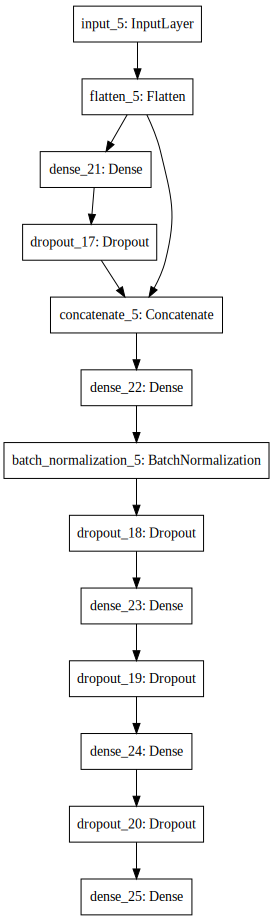

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)  
hist=model.fit_generator(train_gen,steps_per_epoch=200,epochs=20,
                            callbacks=[reduce_lr],
                            validation_data=val_gen,validation_steps=val_step)

Epoch 1/20
200/200 [==============================] - 15s 73ms/step - loss: 0.7907 - val_loss: 0.4517
Epoch 2/20
200/200 [==============================] - 14s 69ms/step - loss: 0.5010 - val_loss: 0.4085
Epoch 3/20
200/200 [==============================] - 14s 69ms/step - loss: 0.4745 - val_loss: 0.4259
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: 0.4570 - val_loss: 0.3968
Epoch 5/20
200/200 [==============================] - 21s 104ms/step - loss: 0.4442 - val_loss: 0.4233
Epoch 6/20
200/200 [==============================] - 19s 93ms/step - loss: 0.4336 - val_loss: 0.4313
Epoch 7/20
200/200 [==============================] - 15s 77ms/step - loss: 0.4204 - val_loss: 0.3910
Epoch 8/20
200/200 [==============================] - 19s 97ms/step - loss: 0.4143 - val_loss: 0.4450
Epoch 9/20
200/200 [==============================] - 16s 78ms/step - loss: 0.4067 - val_loss: 0.4022
Epoch 10/20
200/200 [==============================] - 16s 80ms/step - loss: 0.40

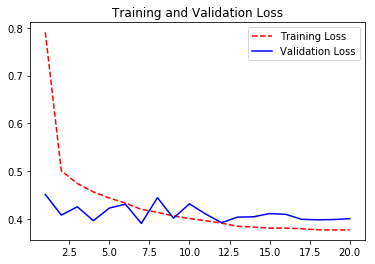

In [27]:
with open('log_DNN.txt','w') as f:
    f.write(str(hist.history))

model.save('md_DNN.h5')

plt_loss(hist)

# Model 2

In [20]:
main_input=Input(shape=(lookback//step,dat.shape[-1]))
x0=Flatten()(main_input)
x=Dense(1024, activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(regularizer))(x0)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(dropout)(x)
x = Concatenate()([x0, x])

x = Dense(512, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(dropout)(x)
x = Concatenate()([x0, x])

x = Dense(256, activation='relu',kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.5)(x)
x = Concatenate()([x0, x])

x = Dense(64, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.4)(x)
x = Concatenate()([x0, x])

x = Dense(32, activation='relu',kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.4)(x)

x = Dense(24, activation='linear',kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

model =  Model(inputs=[main_input], outputs=[x])

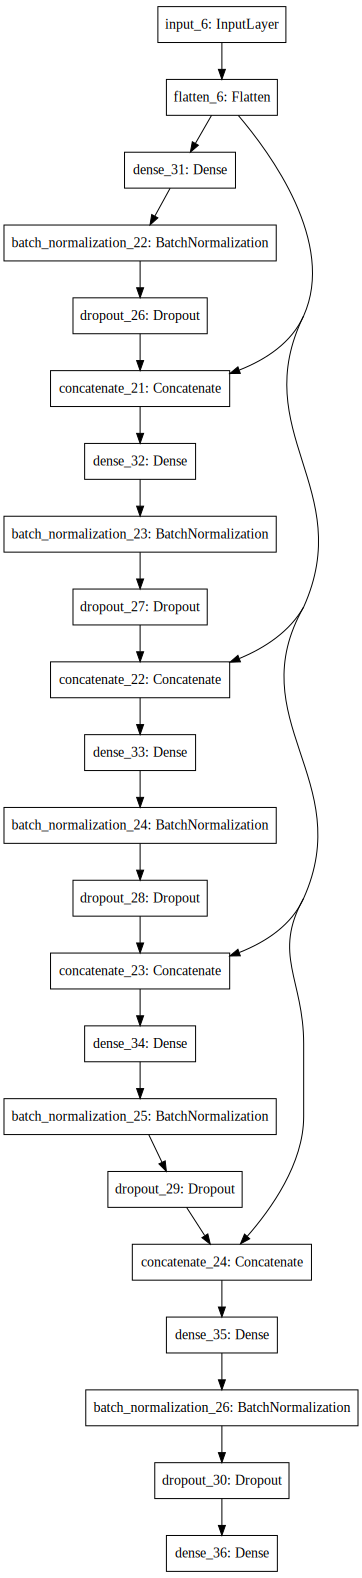

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
model.compile(loss='mae', optimizer=Adam(lr=1e-3))
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=1e-5)  
hist=model.fit_generator(train_gen,steps_per_epoch=200,epochs=40,
                            callbacks=[reduce_lr],
                            validation_data=val_gen,validation_steps=val_step)

Epoch 1/40
200/200 [==============================] - 35s 174ms/step - loss: 1.2088 - val_loss: 0.8231
Epoch 2/40
200/200 [==============================] - 36s 178ms/step - loss: 0.6696 - val_loss: 0.4301
Epoch 3/40
200/200 [==============================] - 37s 183ms/step - loss: 0.3959 - val_loss: 0.3788
Epoch 4/40
200/200 [==============================] - 34s 171ms/step - loss: 0.3579 - val_loss: 0.3797
Epoch 5/40
200/200 [==============================] - 33s 167ms/step - loss: 0.3473 - val_loss: 0.3616
Epoch 6/40
200/200 [==============================] - 33s 167ms/step - loss: 0.3406 - val_loss: 0.3610
Epoch 7/40
200/200 [==============================] - 33s 167ms/step - loss: 0.3346 - val_loss: 0.3588
Epoch 8/40
200/200 [==============================] - 34s 169ms/step - loss: 0.3317 - val_loss: 0.3345
Epoch 9/40
200/200 [==============================] - 34s 168ms/step - loss: 0.3287 - val_loss: 0.3552
Epoch 10/40
200/200 [==============================] - 33s 167ms/step - l

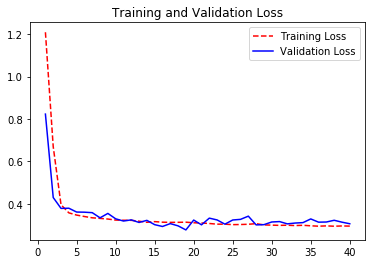

In [24]:
with open('log_DNN_V2.txt','w') as f:
    f.write(str(hist.history))

model.save('md_DNN_V2.h5')

plt_loss(hist)